In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.patches import Patch, Rectangle
from matplotlib.lines import Line2D
from matplotlib import cm
from scipy.stats import hypergeom
from matplotlib import colors as mcolors
from scgenome import cncluster
from scdna_replication_tools.plot_utils import get_rt_cmap, get_phase_cmap, get_clone_cmap, plot_colorbar, make_color_mat_float, plot_clustered_cell_cn_matrix

In [2]:
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True

despine_offset = 10
despine_trim = True

### This notebook will explore the relationship between S-phase enrichment and fitness of the WGD clones in SA906a

The two WGD clones have some of the highest fitness values in the population but they seem to be depleted for S-phase cells relative to the other clones with high fitness. This notebook will explore this relationship further.

In [3]:
def timepoint_to_int(df):
    """Converts the timepoint column to an integer"""
    # get the timepoint column
    timepoints = df['timepoint'].values
    # convert the timepoints to integers
    timepoints = [int(x[1:]) for x in timepoints]
    # add the timepoints to the dataframe
    df['timepoint_int'] = timepoints
    # return the dataframe
    return df
    

def sort_timepoints(df):
    """Sort the dataframe according to clone_id and timepoint_int"""
    # if timepoint_int is not in the dataframe, create such a column
    df = timepoint_to_int(df)
    # sort the dataframe
    df = df.sort_values(by=['clone_id', 'timepoint_int'])
    # return the dataframe
    return df


def fill_in_missing_clones(df, clone_list=None):
    """ If there are clones present at some timepoints but not others, fill in the missing clones with 0s """
    # find the clone list if not specified
    if clone_list is None:
        clone_list = df.clone_id.unique()
    # loop through the clones and timepoints
    for clone in clone_list:
        for timepoint in df.timepoint.unique():
            # if the clone is not present at the timepoint, add a row with 0s
            if clone not in df[df.timepoint == timepoint].clone_id.values:
                new_line = pd.DataFrame({
                    'clone_id': [clone], 'timepoint': [timepoint], 'num_cells_s': [0], 'num_cells_g': [0],
                    'clone_frac_s': [0], 'clone_frac_g': [0], 'positive_p': [0], 'negative_p': [0],
                    'positive_p_adj': [0], 'negative_p_adj': [0], 'timepoint_int': [int(timepoint[1:])]
                })
                # concatenate the new line to the dataframe
                df = pd.concat([df, new_line], ignore_index=True)
    return df


def compute_clone_fracs_vs_time(df):
    """
    Computes the fraction of cells in each clone for each timepoint.
    """
    clone_frac_g_vs_time = np.zeros((len(df.clone_id.unique()), len(df.timepoint_int.unique())))
    clone_frac_s_vs_time = np.zeros((len(df.clone_id.unique()), len(df.timepoint_int.unique())))
    clone_legend = []
    timepoints = df.timepoint_int.unique()
    i = 0
    for clone_id, chunk in df.groupby('clone_id'):
        chunk.sort_values(by='timepoint_int', inplace=True)
        clone_frac_g_vs_time[i] = chunk['clone_frac_g'].values
        clone_frac_s_vs_time[i] = chunk['clone_frac_s'].values
        clone_legend.append(clone_id)
        i += 1
    return timepoints, clone_frac_g_vs_time, clone_frac_s_vs_time, clone_legend

In [4]:

def add_instantaneous_s_and_enrichment(df):
    """Adds a column to the dataframe that contains the observed clone shift in G1/2 population for each clone at each timepoint"""
    # compute the enrichment or depletion for S-phase cells at a given timepoint
    df['clone_frac_diff'] = df['clone_frac_s'] - df['clone_frac_g']

    times = sorted(df.timepoint_int.unique())
    clones = sorted(df.clone_id.unique())

    # this column is a proxy for that clone's instatneous selection coefficient
    df['instantaneous_s'] = np.nan

    # find difference in a clone's number/fraction of cells between two adjacent timepoints
    for t in range(len(times)-1):
        for c in clones:
            t0 = times[t]
            t1 = times[t+1]
            # find the row that corresponds to this clone & time
            row_t0 = df.loc[(df['clone_id']==c) & (df['timepoint_int']==t0)]
            row_t1 = df.loc[(df['clone_id']==c) & (df['timepoint_int']==t1)]
            # find the difference in G1/2-phase fractions between t0 and t1
            frac_diff = row_t1['clone_frac_g'].values[0] - row_t0['clone_frac_g'].values[0]

            # add frac_diff to the dataframe at the appropriate row
            df.loc[(df['clone_id']==c) & (df['timepoint_int']==t0), 'instantaneous_s'] = frac_diff
    
    # compute the log10 value of positive_p so that we can plut this instead of clone_frac_diff
    df['log10_positive_p'] = np.log10(df['positive_p'])
    df['log10_negative_p'] = np.log10(df['negative_p'])

    # subtract the log10 positive_p from the log10 negative_p to create a new column named SPE score
    df['SPE_score'] = df['log10_negative_p'] - df['log10_positive_p']

    return df

In [5]:
dataset = 'SA906a'
# load the cell cycle clone counts for this dataset
df = pd.read_csv('../../analysis/fitness_lines_old/{}/cell_cycle_clone_counts.tsv'.format(dataset), sep='\t')

# sort timepoints based on the timepoint_int column
df = sort_timepoints(df)

# find the set of clone_ids that appear in the union of the treated and untreated samples
clone_list = list(set(df.clone_id.unique()))
# fill in missing clones with 0s
df = fill_in_missing_clones(df, clone_list)

# sort timepoints again now that we've added the earliest untreated timepoint and filled in missing clones
df = sort_timepoints(df)

df

,clone_id,num_cells_s,num_cells_g,clone_frac_s,clone_frac_g,positive_p,negative_p,timepoint,positive_p_adj,negative_p_adj,timepoint_int
11,A,0.0,0.0,0.000000,0.000000,0.000000,1.000000,X10,0.000000,156.000000,10
24,A,0.0,0.0,0.000000,0.000000,0.000000,1.000000,X15,0.000000,156.000000,15
26,A,10.0,25.0,0.026178,0.040128,0.943816,0.056184,X30,147.235252,8.764748,30
39,A,27.0,65.0,0.102662,0.108153,0.571813,0.428187,X40,89.202849,66.797151,40
52,A,52.0,99.0,0.207171,0.210191,0.497302,0.502698,X50,77.579100,78.420900,50
...,...,...,...,...,...,...,...,...,...,...,...
23,M,3.0,10.0,0.012448,0.012034,0.274295,0.725705,X15,42.790085,113.209915,15
38,M,6.0,15.0,0.015707,0.024077,0.868950,0.131050,X30,135.556205,20.443795,30
51,M,0.0,2.0,0.000000,0.003328,0.516383,0.483617,X40,80.555813,75.444187,40
64,M,0.0,0.0,0.000000,0.000000,0.000000,1.000000,X50,0.000000,156.000000,50


In [6]:
# add instantaneous_s and enrichment columns
df = add_instantaneous_s_and_enrichment(df)
df

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,clone_id,num_cells_s,num_cells_g,clone_frac_s,clone_frac_g,positive_p,negative_p,timepoint,positive_p_adj,negative_p_adj,timepoint_int,clone_frac_diff,instantaneous_s,log10_positive_p,log10_negative_p,SPE_score
11,A,0.0,0.0,0.000000,0.000000,0.000000,1.000000,X10,0.000000,156.000000,10,0.000000,0.000000,-inf,0.000000,inf
24,A,0.0,0.0,0.000000,0.000000,0.000000,1.000000,X15,0.000000,156.000000,15,0.000000,0.040128,-inf,0.000000,inf
26,A,10.0,25.0,0.026178,0.040128,0.943816,0.056184,X30,147.235252,8.764748,30,-0.013950,0.068025,-0.025113,-1.250385,-1.225272
39,A,27.0,65.0,0.102662,0.108153,0.571813,0.428187,X40,89.202849,66.797151,40,-0.005491,0.102038,-0.242746,-0.368367,-0.125621
52,A,52.0,99.0,0.207171,0.210191,0.497302,0.502698,X50,77.579100,78.420900,50,-0.003020,-0.078906,-0.303380,-0.298693,0.004687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23,M,3.0,10.0,0.012448,0.012034,0.274295,0.725705,X15,42.790085,113.209915,15,0.000414,0.012043,-0.561781,-0.139240,0.422541
38,M,6.0,15.0,0.015707,0.024077,0.868950,0.131050,X30,135.556205,20.443795,30,-0.008370,-0.020749,-0.061005,-0.882563,-0.821558
51,M,0.0,2.0,0.000000,0.003328,0.516383,0.483617,X40,80.555813,75.444187,40,-0.003328,-0.003328,-0.287028,-0.315499,-0.028471
64,M,0.0,0.0,0.000000,0.000000,0.000000,1.000000,X50,0.000000,156.000000,50,0.000000,0.000000,-inf,0.000000,inf


In [7]:
# annotate which clones are WGD (E and F) vs non-WGD (all others)
df['WGD'] = False
df.loc[df.clone_id.str.contains('E'), 'WGD'] = True
df.loc[df.clone_id.str.contains('F'), 'WGD'] = True
df.WGD.value_counts()

False    66
True     12
Name: WGD, dtype: int64

In [8]:
def add_cumulative_s(df):
    """Adds a column to the dataframe that contains the observed clone shift in G1/2 population for each clone between the first and last timepoints"""
    # compute the enrichment or depletion for S-phase cells at a given timepoint
    df['clone_frac_diff'] = df['clone_frac_s'] - df['clone_frac_g']

    times = sorted(df.timepoint_int.unique())
    clones = sorted(df.clone_id.unique())

    # this column is a proxy for that clone's cumulative selection coefficient
    df['cumulative_s'] = np.nan

    # find difference in a clone's number/fraction of cells between the first and last timepoints
    t_first = times[0]
    t_last = times[-1]
    for c in clones:
        # find the row that corresponds to this clone & first and last timepoints
        row_t_first = df.loc[(df['clone_id']==c) & (df['timepoint_int']==t_first)]
        row_t_last = df.loc[(df['clone_id']==c) & (df['timepoint_int']==t_last)]
        # find the difference in G1/2-phase fractions between the first and last timepoints
        frac_diff = row_t_last['clone_frac_g'].values[0] - row_t_first['clone_frac_g'].values[0]
        # add frac_diff to the dataframe for all rows that correspond to this clone
        df.loc[(df['clone_id']==c), 'cumulative_s'] = frac_diff

    return df


def add_cumulative_SPE(df):
    """
    For a given dataset, compute the S-phase fraction of each cell cycle phase and test
    each clone for enrichment or depletion of S-phase cells
    """
    clones = df['clone_id'].unique()

    # sum all the num_cells_s values belonging to the same clone_id
    num_cells_s = np.array(df.groupby('clone_id').num_cells_s.sum().to_list())
    num_cells_g = np.array(df.groupby('clone_id').num_cells_g.sum().to_list())
        
    # convert clone counts to clone frequencies within each cell cycle phase
    clone_frac_s = num_cells_s / sum(num_cells_s)
    clone_frac_g = num_cells_g / sum(num_cells_g)
    
    # statistical test to see which clones are enriched/depleted for S-phase cells
    positive_pvals = np.zeros(len(clones))
    for i, clone_id in enumerate(clones):

        x = num_cells_s[i] # number of S-phase cells belonging to this clone
        m = sum(num_cells_s) # total number of S-phase cells
        n = sum(num_cells_g) # total number of G1/2-phase cells
        k = int(clone_frac_g[i] * (n + m)) # expected number of G1/2 + S phase cells belonging to this clone
        N = m + n  # total number of cells in entire population
        # use hypergeometric survival function to see if this clone has
        # more S-phase cells than expected (positively selected)
        positive_pvals[i] = hypergeom(M=N, n=m, N=k).sf(x)

    # subtract positive pval from 1 to see if clone has 
    # significantly fewer S-phase cells than expected
    negative_pvals = 1 - positive_pvals
    
    # create a dataframe with one entry per clone with all relevant stats
    df_out = pd.DataFrame({
        'clone_id': clones,
        'num_cells_s': num_cells_s,
        'num_cells_g': num_cells_g,
        'clone_frac_s': clone_frac_s,
        'clone_frac_g': clone_frac_g,
        'positive_p': positive_pvals,
        'negative_p': negative_pvals
    })

    # compute the log10 value of positive_p so that we can plut this instead of clone_frac_diff
    df_out['log10_positive_p'] = np.log10(df_out['positive_p'])
    df_out['log10_negative_p'] = np.log10(df_out['negative_p'])

    # subtract the log10 positive_p from the log10 negative_p to create a new column named SPE score
    df_out['cumulative_SPE'] = df_out['log10_negative_p'] - df_out['log10_positive_p']

    # merge the cumulative SPE score with the original dataframe
    df = df.merge(df_out[['clone_id', 'cumulative_SPE']])
    
    return df


def filter_rows(df, num_cells=10):
    """Filters out rows that do not have a value for instantaneous_s or have few cells"""
    # convert SPE values with -inf to -12 and inf to 12
    df['SPE_score'] = df['SPE_score'].replace(-np.inf, -12)
    df['SPE_score'] = df['SPE_score'].replace(np.inf, 12)
    df = df.loc[df['SPE_score'].notna()]
    df = df.loc[df['instantaneous_s'].notna()]
    df = df.loc[df['num_cells_g'] > num_cells]
    return df


def add_mean_SPE(df):
    '''
    an alternative way to compute cumulative SPE is to take the average of all SPE scores for a given clone that are not NaN or inf
    this is more principled than performing a new hypergeometric test on the cumulative number of cells in each phase because the latter
    merges timepoints together which could produce batch effects
    '''
    df['mean_SPE'] = np.nan
    df_filtered = filter_rows(df, num_cells=10)
    for clone in df.clone_id.unique():
        temp_SPEs = df_filtered.loc[df_filtered.clone_id == clone, 'SPE_score'].values
        # compute the mean across all valid timepoints
        mean_SPE = np.mean(temp_SPEs)
        df.loc[df.clone_id == clone, 'mean_SPE'] = mean_SPE
    return df

In [9]:
df = add_cumulative_s(df)
df = add_cumulative_SPE(df)
df = add_mean_SPE(df)
df

,clone_id,num_cells_s,num_cells_g,clone_frac_s,clone_frac_g,positive_p,negative_p,timepoint,positive_p_adj,negative_p_adj,timepoint_int,clone_frac_diff,instantaneous_s,log10_positive_p,log10_negative_p,SPE_score,WGD,cumulative_s,cumulative_SPE,mean_SPE
0,A,0.0,0.0,0.000000,0.000000,0.000000,1.000000,X10,0.000000,156.000000,10,0.000000,0.000000,-inf,0.000000,12.000000,False,0.131285,4.172635,-0.448735
1,A,0.0,0.0,0.000000,0.000000,0.000000,1.000000,X15,0.000000,156.000000,15,0.000000,0.040128,-inf,0.000000,12.000000,False,0.131285,4.172635,-0.448735
2,A,10.0,25.0,0.026178,0.040128,0.943816,0.056184,X30,147.235252,8.764748,30,-0.013950,0.068025,-0.025113,-1.250385,-1.225272,False,0.131285,4.172635,-0.448735
3,A,27.0,65.0,0.102662,0.108153,0.571813,0.428187,X40,89.202849,66.797151,40,-0.005491,0.102038,-0.242746,-0.368367,-0.125621,False,0.131285,4.172635,-0.448735
4,A,52.0,99.0,0.207171,0.210191,0.497302,0.502698,X50,77.579100,78.420900,50,-0.003020,-0.078906,-0.303380,-0.298693,0.004687,False,0.131285,4.172635,-0.448735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,M,3.0,10.0,0.012448,0.012034,0.274295,0.725705,X15,42.790085,113.209915,15,0.000414,0.012043,-0.561781,-0.139240,0.422541,False,-0.008299,-0.782297,-0.821558
74,M,6.0,15.0,0.015707,0.024077,0.868950,0.131050,X30,135.556205,20.443795,30,-0.008370,-0.020749,-0.061005,-0.882563,-0.821558,False,-0.008299,-0.782297,-0.821558
75,M,0.0,2.0,0.000000,0.003328,0.516383,0.483617,X40,80.555813,75.444187,40,-0.003328,-0.003328,-0.287028,-0.315499,-0.028471,False,-0.008299,-0.782297,-0.821558
76,M,0.0,0.0,0.000000,0.000000,0.000000,1.000000,X50,0.000000,156.000000,50,0.000000,0.000000,-inf,0.000000,12.000000,False,-0.008299,-0.782297,-0.821558


In [10]:
# print all the rows in df where there are less than 10 cells in G1/2 phase
df.loc[df.num_cells_g < 10]

,clone_id,num_cells_s,num_cells_g,clone_frac_s,clone_frac_g,positive_p,negative_p,timepoint,positive_p_adj,negative_p_adj,timepoint_int,clone_frac_diff,instantaneous_s,log10_positive_p,log10_negative_p,SPE_score,WGD,cumulative_s,cumulative_SPE,mean_SPE
0,A,0.0,0.0,0.000000,0.000000,0.000000,1.000000,X10,0.000000,156.000000,10,0.000000,0.000000,-inf,0.000000,12.000000,False,0.131285,4.172635,-0.448735
1,A,0.0,0.0,0.000000,0.000000,0.000000,1.000000,X15,0.000000,156.000000,15,0.000000,0.040128,-inf,0.000000,12.000000,False,0.131285,4.172635,-0.448735
6,B,0.0,4.0,0.000000,0.005533,0.306035,0.693965,X10,47.741478,108.258522,10,-0.005533,0.016128,-0.514229,-0.158663,0.355566,False,0.027987,2.477488,-0.501455
12,C,0.0,1.0,0.000000,0.001383,0.087121,0.912879,X10,13.590909,142.409091,10,-0.001383,0.008244,-1.059876,-0.039587,1.020289,False,-0.001383,1.398316,-0.896967
13,C,0.0,8.0,0.000000,0.009627,0.922600,0.077400,X15,143.925648,12.074352,15,-0.009627,0.107548,-0.034986,-1.111261,-1.076274,False,-0.001383,1.398316,-0.896967
16,C,0.0,1.0,0.000000,0.002123,0.347645,0.652355,X50,54.232687,101.767313,50,-0.002123,-0.002123,-0.458863,-0.185516,0.273347,False,-0.001383,1.398316,-0.896967
17,C,0.0,0.0,0.000000,0.000000,0.000000,1.000000,X57,0.000000,156.000000,57,0.000000,NaN,-inf,0.000000,12.000000,False,-0.001383,1.398316,-0.896967
21,D,1.0,7.0,0.003802,0.011647,0.858934,0.141066,X40,133.993651,22.006349,40,-0.007845,-0.011647,-0.066040,-0.850577,-0.784536,False,-0.922545,-10.787290,1.161462
22,D,1.0,0.0,0.003984,0.000000,0.000000,1.000000,X50,0.000000,156.000000,50,0.003984,0.000000,-inf,0.000000,12.000000,False,-0.922545,-10.787290,1.161462
23,D,2.0,0.0,0.009346,0.000000,0.000000,1.000000,X57,0.000000,156.000000,57,0.009346,NaN,-inf,0.000000,12.000000,False,-0.922545,-10.787290,1.161462


In [11]:
summary_df = df[['clone_id', 'WGD', 'cumulative_s', 'cumulative_SPE', 'mean_SPE']].drop_duplicates()
summary_df

,clone_id,WGD,cumulative_s,cumulative_SPE,mean_SPE
0,A,False,0.131285,4.172635,-0.448735
6,B,False,0.027987,2.477488,-0.501455
12,C,False,-0.001383,1.398316,-0.896967
18,D,False,-0.922545,-10.787290,1.161462
24,E,True,0.659218,10.622318,0.054709
30,F,True,0.146797,-0.637790,-2.301352
36,G,False,-0.017981,-0.319436,0.492890
42,H,False,-0.005533,2.304633,1.483268
48,I,False,-0.016598,2.695035,1.168844
54,J,False,0.004203,0.778356,-0.555666


In [12]:
def compute_column_rank(df, column_name):
    """Computes the rank of each clone based on the values in the specified column but return the df in the original order"""
    # sort the dataframe by the specified column
    df_sorted = df.sort_values(by=column_name, ascending=False)
    # create a new column that contains the rank of each clone
    df_sorted['{}_rank'.format(column_name)] = range(1, len(df_sorted)+1) 
    # sort the dataframe by the clone_id column
    df_sorted = df_sorted.sort_values(by='clone_id')
    # return the sorted dataframe
    return df_sorted

# compute the rank of each clone based on cumulative_s, cumulative_SPE, and mean_SPE
summary_df = compute_column_rank(summary_df, 'cumulative_s')
summary_df = compute_column_rank(summary_df, 'cumulative_SPE')
summary_df = compute_column_rank(summary_df, 'mean_SPE')
summary_df

,clone_id,WGD,cumulative_s,cumulative_SPE,mean_SPE,cumulative_s_rank,cumulative_SPE_rank,mean_SPE_rank
0,A,False,0.131285,4.172635,-0.448735,3,3,8
6,B,False,0.027987,2.477488,-0.501455,4,5,9
12,C,False,-0.001383,1.398316,-0.896967,7,8,12
18,D,False,-0.922545,-10.787290,1.161462,13,13,4
24,E,True,0.659218,10.622318,0.054709,1,2,7
30,F,True,0.146797,-0.637790,-2.301352,2,11,13
36,G,False,-0.017981,-0.319436,0.492890,12,10,6
42,H,False,-0.005533,2.304633,1.483268,9,6,2
48,I,False,-0.016598,2.695035,1.168844,11,4,3
54,J,False,0.004203,0.778356,-0.555666,6,9,10


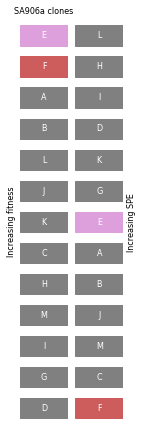

In [13]:
def plot_fitness_SPE_ranks(df, ax0, ax1, col0='cumulative_s', col1='mean_SPE'):
    ''' 
    Given a set of rows in df, plot a colored patch of each clone ID sorted by the SPE score.
    The left subplot (ax0) that only plots rows where site=='adnexa' and the right subplot (ax1) that only plots rows where site=='omentum'.
    '''

    # sort the dataframes
    df0 = df.sort_values(by=col0, ascending=True)
    df1 = df.sort_values(by=col1, ascending=True)

    # plot adnexa clone IDs sorted by SPE score
    # plot them vertically where each clone ID is a rectangle colored by get_clone_cmap()
    clone_cmap = get_clone_cmap()
    height = 0.05
    for temp_df, ax in zip([df0, df1], [ax0, ax1]):
        yspacing = (1 / len(temp_df)) - height
        y = yspacing / 2
        for row in temp_df.iterrows():
            c = row[1]['clone_id']
            wgd = row[1]['WGD']
            if wgd:
                color = clone_cmap[c]
            else:
                color = 'grey'
            # clone_legend_elements.append(Patch(facecolor=color, label=c))
            ax.add_patch(Rectangle((0, y), 1, height, color=color))
            # superimpose the clone ID as text over the patch
            ax.text(0.5, y+(height/2), c, ha='center', va='center', size=MEDIUM_SIZE, color='white')
            y += height + yspacing
        
        # remove all axis borders and ticks
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])
    
    ax0.set_title('SA906a clones', fontsize=MEDIUM_SIZE)
    ax0.set_ylabel('Increasing fitness', fontsize=MEDIUM_SIZE)
    
    # write the ylabel for ax1 to the right of the plot
    ax1.yaxis.set_label_position("right")
    ax1.set_ylabel('Increasing SPE', fontsize=MEDIUM_SIZE)

    return ax0, ax1

fig, ax = plt.subplots(1, 2, figsize=(2, 6), tight_layout=True)
plot_fitness_SPE_ranks(summary_df, ax[0], ax[1])
plt.show()

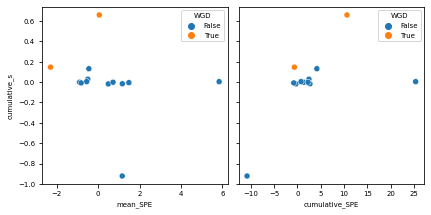

In [14]:
# make a scatterplot of cumulative s vs mean SPE, colored by WGD status
fig, ax = plt.subplots(1, 2, figsize=(6, 3), tight_layout=True, sharey=True)
sns.scatterplot(data=summary_df, x='mean_SPE', y='cumulative_s', hue='WGD', ax=ax[0])
sns.scatterplot(data=summary_df, x='cumulative_SPE', y='cumulative_s', hue='WGD', ax=ax[1])
plt.show()

### Explore other ways for plotting the data

In [23]:
def plot_s_phase_enrichment_by_wgd(df, ax0, ax1, pt_size=5):
    ''' Plot the S-phase enrichment of WGD clones in ax0 and non-WGD clones in ax1. '''
    # compute the maximum and minimum timepoints
    df['timepoint_int'] = df['timepoint_int'].astype(int)
    max_time = df['timepoint_int'].max()
    min_time = df['timepoint_int'].min()

    pthresh = 1e-2

    # create custom legend for clones & timepoints
    clone_cmap = get_clone_cmap()
    viridis = cm.get_cmap('viridis', 256)
    timepoint_cmap = {}
    clone_legend_elements = [
        Line2D([0], [0], marker='^', color='w', label='enriched'.format(pthresh), markerfacecolor='k', markersize=pt_size),
        Line2D([0], [0], marker='v', color='w', label='depleted'.format(pthresh), markerfacecolor='k', markersize=pt_size)
    ]
    timepoint_legend_elements = clone_legend_elements.copy()
    for i, c in enumerate(sorted(df.clone_id.unique())):
        color = clone_cmap[c]
        # clone_legend_elements.append(Patch(facecolor=color, label=c))

    for i, t in enumerate(sorted(df.timepoint_int.unique())):
        color = viridis((t - min_time) / (max_time - min_time))
        timepoint_str = 'X{}'.format(t)
        timepoint_cmap[timepoint_str] = color
        # timepoint_legend_elements.append(Patch(facecolor=color, label=timepoint_str))

    # draw scatterplot comparing the relative fraction of each clone in S vs G1/2 phases
    for i, row in df.iterrows():
        clone_id = row['clone_id']
        temp_ax = ax0 if row['WGD'] else ax1
        if row['positive_p_adj'] < pthresh:
            temp_ax.scatter(x=row['clone_frac_g'], y=row['clone_frac_s'], color=clone_cmap[clone_id], marker='^', s=pt_size)
        elif row['negative_p_adj'] < pthresh:
            temp_ax.scatter(x=row['clone_frac_g'], y=row['clone_frac_s'], color=clone_cmap[clone_id], marker='v', s=pt_size)
        else:
            temp_ax.scatter(x=row['clone_frac_g'], y=row['clone_frac_s'], color=clone_cmap[clone_id], s=pt_size)

    # ax0.legend(handles=clone_legend_elements, title='clone')
    # ax0.legend(handles=clone_legend_elements, title='S-phase', frameon=False, loc='lower right')
    ax0.set_title('SPE of WGD clones')
    ax1.set_title('SPE of NGD clones')
    for ax in [ax0, ax1]:
        ax.set_xlabel('G1/2 fraction')
        ax.set_ylabel('S fraction')
        ax.set_xticks([0, 0.5, 1])
        ax.set_yticks([0, 0.5, 1])
    
    # draw y=x line where we expect "neutral" clones to lie
    lims = [
        np.min([ax0.get_xlim(), ax0.get_ylim()]),  # min of both axes
        np.max([ax0.get_xlim(), ax0.get_ylim()]),  # max of both axes
    ]
    ax0.plot(lims, lims, 'k--', alpha=0.25, zorder=0)
    ax1.plot(lims, lims, 'k--', alpha=0.25, zorder=0)

    # despine the axes
    sns.despine(ax=ax0, offset=False, trim=despine_trim)
    sns.despine(ax=ax1, offset=False, trim=despine_trim)

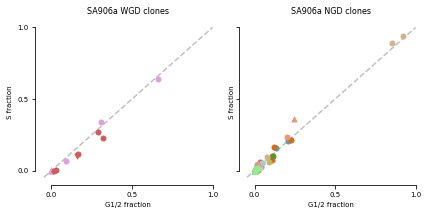

In [16]:
# plot the S-phase enrichment of WGD clones in ax0 and non-WGD clones in ax1
fig, ax = plt.subplots(1, 2, figsize=(6, 3), tight_layout=True, sharey=True)
plot_s_phase_enrichment_by_wgd(df, ax[0], ax[1], pt_size=25)
plt.show()

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


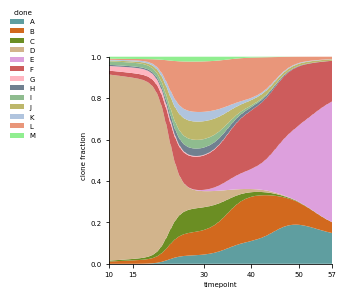

In [24]:
def plot_clone_muller(
        df, ax_g, interpolate=True, std=5, clone_cmap=get_clone_cmap(), 
        legend_kwargs=dict(title='clone', bbox_to_anchor=(-0.3, 1.2), frameon=False, ncol=1)
    ):
    """
    Plots the evolution of clones over time for each cell cycle phase. 
    """
    # split the dataframe based on cell cycle and find the fraction of cells in each clone at each timepoint for each cell cycle phase
    timepoints, clone_frac_g_vs_time, clone_frac_s_vs_time, clone_legend = compute_clone_fracs_vs_time(df)
    og_timepoints = timepoints

    if interpolate:
        clone_frac_g_vs_time = pd.DataFrame(clone_frac_g_vs_time, index=clone_legend, columns=timepoints)
            
        # add columns with NaNs for the 0.5 intervals betweeen timepoints
        for i in range(min(timepoints), max(timepoints)):
            for frac in np.linspace(0.1, 0.9, 9):
                clone_frac_g_vs_time[i + frac] = np.nan

        # sort the columns based on timepoint
        clone_frac_g_vs_time = clone_frac_g_vs_time.reindex(sorted(clone_frac_g_vs_time.columns), axis=1)
        timepoints = clone_frac_g_vs_time.columns

        # # interpolate the NaNs
        # clone_frac_g_vs_time = clone_frac_g_vs_time.interpolate(method='spline', order=3, axis=1)
        clone_frac_g_vs_time = clone_frac_g_vs_time.T.rolling(len(timepoints), 1, True, 'gaussian').mean(std=std).T
    
    # set x-axis ticks to all the timepoints we have measurements for
    ax_g.set_xticks(og_timepoints)

    clone_colors = [clone_cmap[x] for x in clone_legend]

    # plot as a stackplot
    baseline = 'zero'
    ax_g.stackplot(timepoints, clone_frac_g_vs_time, labels=clone_legend, baseline=baseline, colors=clone_colors)
    ax_g.set_ylabel('clone fraction')
    ax_g.set_xlabel('timepoint')
    # add a legend and move it to the left of the y-axis label
    ax_g.legend(**legend_kwargs)
    # set the x-axis limits to be the very first and last timepoints
    ax_g.set_xlim(min(timepoints), max(timepoints))
    # despine the axes
    sns.despine(ax=ax_g, offset=False, trim=despine_trim)


# plot clone fractions for each phase & timepoint in the form of a stackplot
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_clone_muller(df, ax, std=40)
plt.show()

In [18]:
def plot_s_predictiveness(df, ax, title=None, s=5):
    """Plots the observed clone shift in G1/2 population vs. the clone's S-phase enrichment/depletion"""
    # fit a regression line to the data
    sns.regplot(y='instantaneous_s', x='SPE_score', data=df, ax=ax, scatter=False, color='black', line_kws={'lw': 1})

    # rename columns clone_id to Clone ID and timepoint to Timepoint for plotting purposes
    df = df.rename(columns={'clone_id': 'clone ID'})

    # create a seaborn scatterplot comparing the observed clone shift in G1/2 population to the clone's S-phase enrichment/depletion
    sns.scatterplot(y='instantaneous_s', x='SPE_score', data=df, hue='clone ID', style='timepoint', palette=get_clone_cmap(), ax=ax, s=s)
    # set the y-axis label
    ax.set_ylabel('expansion score')
    # set the x-axis label
    ax.set_xlabel('SPE score')
    # set the title
    if title is not None:
        ax.set_title(title)

    # remove the legend
    ax.get_legend().remove()

    # expand the x axis limits to be slightly larger than the data
    ax.set_xlim(left=ax.get_xlim()[0] - 1, right=ax.get_xlim()[1] + 1)

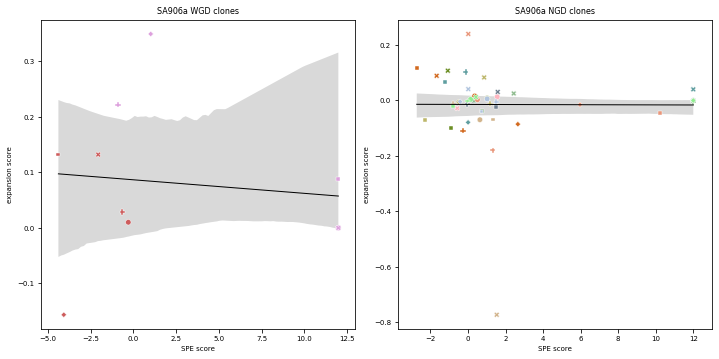

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)

# plot just the WGD data
df_WGD = df.loc[df.WGD == True]
plot_s_predictiveness(df_WGD, ax[0], title='{} WGD clones'.format(dataset), s=30)

# plot just the non-WGD data
df_NGD = df.loc[df.WGD == False]
plot_s_predictiveness(df_NGD, ax[1], title='{} NGD clones'.format(dataset), s=30)

plt.show()

### Load the filtered PERT output to plot CN heatmaps

In [20]:
# load long-form dataframes that have the PERT output for each bin
prefix = '../../analysis/fitness_lines_old/{}/'.format(dataset)
cn_s = pd.read_csv(prefix+'s_phase_cells_with_scRT_filtered.tsv', dtype={'chr':str}, sep='\t')
cn_g = pd.read_csv(prefix+'g1_phase_cells_with_scRT_filtered.tsv', dtype={'chr':str}, sep='\t')
# combine the 081 dataframes
cn_s['phase'] = 1
cn_g['phase'] = 0
cn = pd.concat([cn_s, cn_g], ignore_index=True)
cn.head()

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (29) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,chr,start,end,cell_id,reads,gc,map,copy,state,total_mapped_reads_hmmcopy,...,rpm_auto,rep_auto,cn_bk,rep_bk,frac_cn0,rpm_auto_norm,rep_auto_norm,label,timepoint,phase
0,1,1000001,1500000,SA906-A96210C-R50-C13,460,0.598332,0.982072,5.525238,5,1998458,...,0.102058,0.022714,13,633,0.000183,-0.076967,-0.01224,p53-/- a,X15,1
1,1,1500001,2000000,SA906-A96210C-R50-C13,467,0.539498,0.963004,4.744966,5,1998458,...,0.102058,0.022714,13,633,0.000183,-0.076967,-0.01224,p53-/- a,X15,1
2,1,2000001,2500000,SA906-A96210C-R50-C13,541,0.594508,0.997066,6.391802,5,1998458,...,0.102058,0.022714,13,633,0.000183,-0.076967,-0.01224,p53-/- a,X15,1
3,1,3000001,3500000,SA906-A96210C-R50-C13,473,0.584572,0.996989,5.376251,5,1998458,...,0.102058,0.022714,13,633,0.000183,-0.076967,-0.01224,p53-/- a,X15,1
4,1,4000001,4500000,SA906-A96210C-R50-C13,523,0.482574,0.996234,5.200074,5,1998458,...,0.102058,0.022714,13,633,0.000183,-0.076967,-0.01224,p53-/- a,X15,1


In [21]:
def plot_pert_cn_heatmap(
    cn, ax_heatmap, ax_clone, ax_phase,
    clone_col='clone_id', phase_col='phase',
    output_cn_col='model_cn_state', secondary_sort_col='model_tau',
    phase_cmap=get_phase_cmap(), clone_cmap=get_clone_cmap(),
    chrom_labels_to_remove=[]
    ):
    ''' 
    Plot PERT output heatmaps for S-phase and G1/2-phase cells. 
    
    Parameters
    ----------
    cn : pandas.DataFrame
        long-form dataframe of S- and G1/2-phase cells with pert model results.
        this dataframe should have the following columns in addition to those specified by additional parameters:
            - chr (categorical)
            - start (int)
            - end (int)
            - cell_id (str)
    ax_heatmap : matplotlib.axes.Axes
        axis for the CN heatmap
    ax_clone : matplotlib.axes.Axes
        axis for the clone ID colorbar annotations
    ax_phase : matplotlib.axes.Axes
        axis for the cell cycle phase colorbar annotations
    clone_col : str
        column name for clone IDs
    phase_col : str
        column name for secondary sorting of cells (e.g. time in S-phase or cell cycle phase)
    output_cn_col : str
        column name for output CN states (from pert)
    phase_cmap : matplotlib.colors.ListedColormap
        colormap for cell cycle phases
    clone_cmap : matplotlib.colors.ListedColormap
        colormap for clone IDs
    chrom_labels_to_remove : list
        chromosomes to remove from x-axis to avoid crowding
    '''

    # create mapping of clone IDs
    cluster_col = 'cluster_id'
    clone_dict = dict([(y,x+1) for x,y in enumerate(sorted(cn[clone_col].unique()))])
    cn[cluster_col] = cn[clone_col]
    cn = cn.replace({cluster_col: clone_dict})

    # plot the CN states for the S-phase cells
    plot_data = plot_clustered_cell_cn_matrix(
        ax_heatmap, cn, output_cn_col, cluster_field_name=cluster_col, secondary_field_name=secondary_sort_col, chrom_boundary_width=0.5, chrom_labels_to_remove=chrom_labels_to_remove
    )

    # turn off the y-axis ticks in all subplots
    for ax in [ax_heatmap, ax_clone, ax_phase]:
        ax.set_yticks([])
        ax.set_ylabel('')

    # add the colorbars for clone_id and model_tau
    if len(clone_dict) > 1:
        cell_ids = plot_data.columns.get_level_values(0).values
        cluster_ids = plot_data.columns.get_level_values(1).values
        # use mcolors to change every element in the dict to rgba
        for key in clone_cmap.keys():
            clone_cmap[key] = mcolors.to_rgba(clone_cmap[key])
        color_mat, _ = cncluster.get_cluster_colors(cluster_ids, color_map=clone_cmap, return_map=True)

        # get array of the phase values that match the cell_id order
        condensed_cn = cn[['cell_id', phase_col]].drop_duplicates()
        phase_array = []
        for cell in cell_ids:
            phase = condensed_cn[condensed_cn['cell_id'] == cell][phase_col].values[0]
            phase_array.append(phase)
        
        # use mcolors to change every element of the phase cmap dict to rgba
        for key in phase_cmap.keys():
            phase_cmap[key] = mcolors.to_rgba(phase_cmap[key])
        phase_color_mat, _ = cncluster.get_cluster_colors(phase_array, color_map=phase_cmap, return_map=True)

        # create color bar that shows clone id for each row in heatmap
        plot_colorbar(ax_clone, color_mat)

        # create color bar that shows secondary sort value for each row in heatmap
        plot_colorbar(ax_phase, phase_color_mat)

    # add the x-axis labels
    ax_heatmap.set_xlabel('chromosome')
    ax_clone.set_xticks([0.0])
    ax_clone.set_xticklabels(['clone'], rotation=90)
    ax_phase.set_xticks([0.0])
    ax_phase.set_xticklabels(['phase'], rotation=90)
    ax_clone.set_ylabel('{} cells'.format(cn.cell_id.nunique()))
    ax_heatmap.set_title('PERT somatic CN states')

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


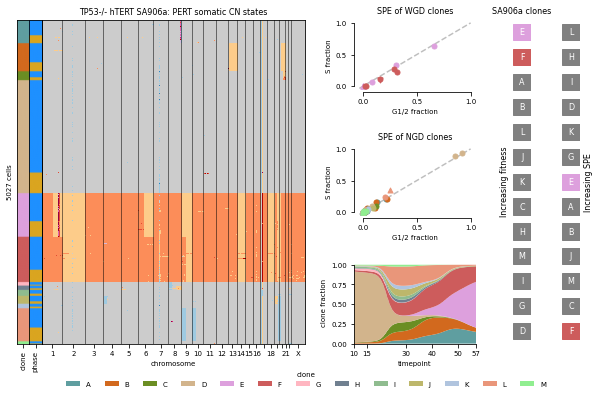

In [28]:
fig = plt.figure(figsize=(8.5, 5))

# add a heatmap with 3 barplots to the left in the left half of the figure
ax0 = fig.add_axes([0.08, 0.05, 0.43, 0.9])
ax1 = fig.add_axes([0.04, 0.05, 0.02, 0.9])
# ax1.set_title('ax1')
ax2 = fig.add_axes([0.06, 0.05, 0.02, 0.9])
# ax2.set_title('ax2')

# add three vertically spaced scatterplots in the middle-right that run from top to bottom
ax3 = fig.add_axes([0.59, 0.75, 0.2, 0.2])
# ax3.set_title('ax3')
ax4 = fig.add_axes([0.59, 0.4, 0.2, 0.2])
# ax4.set_title('ax4')
ax5 = fig.add_axes([0.59, 0.05, 0.2, 0.23])
# ax5.set_title('ax5')

# add two horizontally spaced subplots on the far right that run from top to bottom
ax6 = fig.add_axes([0.85, 0.05, 0.03, 0.9])
# ax6.set_title('ax6')
ax7 = fig.add_axes([0.93, 0.05, 0.03, 0.9])
# ax7.set_title('ax7')

plot_pert_cn_heatmap(
    cn, ax0, ax1, ax2,
    secondary_sort_col='phase',
    chrom_labels_to_remove=['17', '19', '20', '22']
)
ax0.set_title('TP53-/- hTERT SA906a: PERT somatic CN states')

# plot the S-phase enrichment of WGD clones in ax0 and non-WGD clones in ax3 and ax4
plot_s_phase_enrichment_by_wgd(df, ax3, ax4, pt_size=25)

# plot the muller plot for G1/2-phase cells in ax5
plot_clone_muller(df, ax5, std=40, legend_kwargs=dict(title='clone', bbox_to_anchor=(-2.4, -0.6), loc='lower left', frameon=False, ncol=13))

# plot the relative ranking of clone fitness and SPE scores in ax6 and ax7
plot_fitness_SPE_ranks(summary_df, ax6, ax7)

# save the figure
fig.savefig('../../manuscript/supplementary_figs/figS12.pdf', bbox_inches='tight', dpi=300)

plt.show()